# Optimal `max_features` for `RandomForestRegressor`

Some code borrowed from https://github.com/thomasjpfan/sk_encoder_cv.

In [1]:
%load_ext lab_black

In [2]:
from dataclasses import dataclass
from math import sqrt
from typing import List
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import seaborn as sns


@dataclass
class DataInfo:
    data_name: str
    data_id: int
    is_classification: bool
    columns_to_remove: Optional[List[str]] = None


DATA_INFOS = {
    "ames": DataInfo(
        data_name="ames",
        data_id=42165,
        is_classification=False,
        columns_to_remove=["Id"],
    ),
    "taxi": DataInfo(
        data_name="taxi",
        data_id=42729,
        is_classification=False,
    ),
    "Allstate_Claims_Severity": DataInfo(
        data_name="Allstate_Claims_Severity",
        data_id=42571,
        is_classification=False,
    ),
    "medical_charges_nominal": DataInfo(
        data_name="medical_charges_nominal",
        data_id=42559,
        is_classification=False,
    ),
    "Bike_Sharing_Demand": DataInfo(
        data_name="Bike_Sharing_Demand",
        data_id=42712,
        is_classification=False,
    ),
    "Brazilian_houses": DataInfo(
        data_name="Brazilian_houses",
        data_id=42688,
        is_classification=False,
    ),
    "delays_zurich_transport": DataInfo(
        data_name="delays_zurich_transport",
        data_id=42495,
        is_classification=False,
    ),
    "nyc-taxi-green-dec-2016": DataInfo(
        data_name="nyc-taxi-green-dec-2016", data_id=42208, is_classification=False
    ),
    "black_friday": DataInfo(
        data_name="black_friday",
        data_id=41540,
        is_classification=False,
    ),
    "colleges": DataInfo(
        data_name="colleges",
        data_id=42159,
        is_classification=False,
    ),
    "la_crimes": DataInfo(
        data_name="la_crimes",
        data_id=42160,
        is_classification=False,
    ),
    "particulate-matter-ukair-2017": DataInfo(
        data_name="particulate-matter-ukair-2017",
        data_id=42207,
        is_classification=False,
    ),
    "diamonds": DataInfo(
        data_name="diamonds",
        data_id=42225,
        is_classification=False,
        columns_to_remove=["x", "y", "z"],
    ),
}


def fetch_openml_and_clean(data_info: DataInfo):
    print(f"fetching and loading {data_info.data_name} dataset from openml")
    X, y = fetch_openml(data_id=data_info.data_id, return_X_y=True, as_frame=True)

    if data_info.columns_to_remove:
        X = X.drop(data_info.columns_to_remove, axis="columns")

    if data_info.is_classification:
        y = LabelEncoder().fit_transform(y)

    return X, y


def load_data(data_info):
    X, y = fetch_openml_and_clean(data_info)
    n_cats = X.select_dtypes(include=["object", "category"]).shape[1]
    n_samples, n_features = X.shape

    return {
        "X": X,
        "y": y,
        "dataset_name": data_info.data_name,
        "categorical features": n_cats,
        "n_features": n_features,
        "n_samples": n_samples,
        "is_classification": data_info.is_classification,
        "openml_url": f"https://www.openml.org/d/{data_info.data_id}",
    }


def get_estimator(data_info, max_features):
    if data_info.is_classification:
        RF = RandomForestClassifier
    else:
        RF = RandomForestRegressor

    prep = ColumnTransformer(
        [
            (
                "cat",
                make_pipeline(
                    SimpleImputer(strategy="constant"),
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value", unknown_value=-1
                    ),
                ),
                make_column_selector(dtype_include=["object", "category"]),
            ),
            ("num", SimpleImputer(), make_column_selector(dtype_include="number")),
        ]
    )

    return Pipeline(
        [
            ("prep", prep),
            (
                "est",
                RF(random_state=42, n_estimators=100, max_features=max_features),
            ),
        ]
    )

In [3]:
def run_single_benchmark(data_str):
    print(f"running benchmark for {data_str}")
    data_info = DATA_INFOS[data_str]
    meta_data = load_data(data_info=data_info)
    X, y = meta_data["X"], meta_data["y"]
    if data_info.is_classification:
        scoring = ["neg_log_loss"]
    else:
        scoring = ["neg_mean_squared_error"]

    n_samples, n_features = X.shape
    result_list = []

    for n, name in [
        (int(n_features / 3), "p/3"),
        (int(sqrt(n_features)), "sqrt(p)"),
        (int(0.9 * n_features), "0.9p"),
        (n_features, "p"),
    ]:
        estimator = get_estimator(data_info=data_info, max_features=n)

        results = cross_validate(
            estimator,
            X,
            y,
            cv=KFold(n_splits=5, shuffle=True, random_state=4321),
            n_jobs=-1,
            verbose=1,
            scoring=scoring,
        )
        result_list.append(
            {
                "dataset": meta_data["dataset_name"],
                "n_samples": n_samples,
                "n_features": n_features,
                "max_features": name,
                "fit_time": np.sum(results["fit_time"]),
                "mse": -np.nanmean(results["test_neg_mean_squared_error"]),
                "mse_std": np.nanstd(results["test_neg_mean_squared_error"]),
            }
        )

    return result_list

In [4]:
# x = run_single_benchmark("diamonds")
# x

In [5]:
%%time
results = [run_single_benchmark(x) for x in DATA_INFOS.keys()]

running benchmark for ames
fetching and loading ames dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


running benchmark for taxi
fetching and loading taxi dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.9min remaining:  8.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.0min finished


running benchmark for Allstate_Claims_Severity
fetching and loading Allstate_Claims_Severity dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  9.6min remaining: 14.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.5min remaining: 15.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.6min finished


running benchmark for medical_charges_nominal
fetching and loading medical_charges_nominal dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   43.7s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


running benchmark for Bike_Sharing_Demand
fetching and loading Bike_Sharing_Demand dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


running benchmark for Brazilian_houses
fetching and loading Brazilian_houses dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


running benchmark for delays_zurich_transport
fetching and loading delays_zurich_transport dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.6s remaining:   20.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.0s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


running benchmark for nyc-taxi-green-dec-2016
fetching and loading nyc-taxi-green-dec-2016 dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


running benchmark for black_friday
fetching and loading black_friday dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.8s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.3s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   27.6s remaining:   41.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.7s remaining:   46.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


running benchmark for colleges
fetching and loading colleges dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
/Users/lorentzen/github/python3_general/lib/python3.7/site-packages/ipykernel_launcher.p

running benchmark for la_crimes
fetching and loading la_crimes dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 15.2min remaining: 22.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 33.9min remaining: 50.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 34.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 37.8min remaining: 56.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 37.8min finished


running benchmark for particulate-matter-ukair-2017
fetching and loading particulate-matter-ukair-2017 dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


running benchmark for diamonds
fetching and loading diamonds dataset from openml


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.7s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished


CPU times: user 4min 19s, sys: 26.4 s, total: 4min 45s
Wall time: 2h 55min 21s


In [6]:
df = pd.DataFrame([item for run in results for item in run])

In [5]:
# df.to_parquet("random_forests_max_features.parquet", engine="pyarrow")
df = pd.read_parquet("random_forests_max_features.parquet")

In [6]:
df

,dataset,n_samples,n_features,max_features,fit_time,mse,mse_std
0,ames,1460,79,p/3,3.016021,8.283968e+08,2.924086e+08
1,ames,1460,79,sqrt(p),1.537219,8.558911e+08,2.757982e+08
2,ames,1460,79,0.9p,6.205986,8.506720e+08,2.850547e+08
3,ames,1460,79,p,6.984907,8.518196e+08,2.753024e+08
4,taxi,581835,18,p/3,795.350663,3.032839e+00,2.711375e-01
5,taxi,581835,18,sqrt(p),591.737784,3.243551e+00,3.208481e-01
6,taxi,581835,18,0.9p,1648.497312,2.825315e+00,2.582628e-01
7,taxi,581835,18,p,1763.070048,2.845630e+00,2.645234e-01
8,Allstate_Claims_Severity,188318,130,p/3,1098.282751,3.831934e+06,1.726923e+05
9,Allstate_Claims_Severity,188318,130,sqrt(p),424.375716,3.848965e+06,2.098695e+05


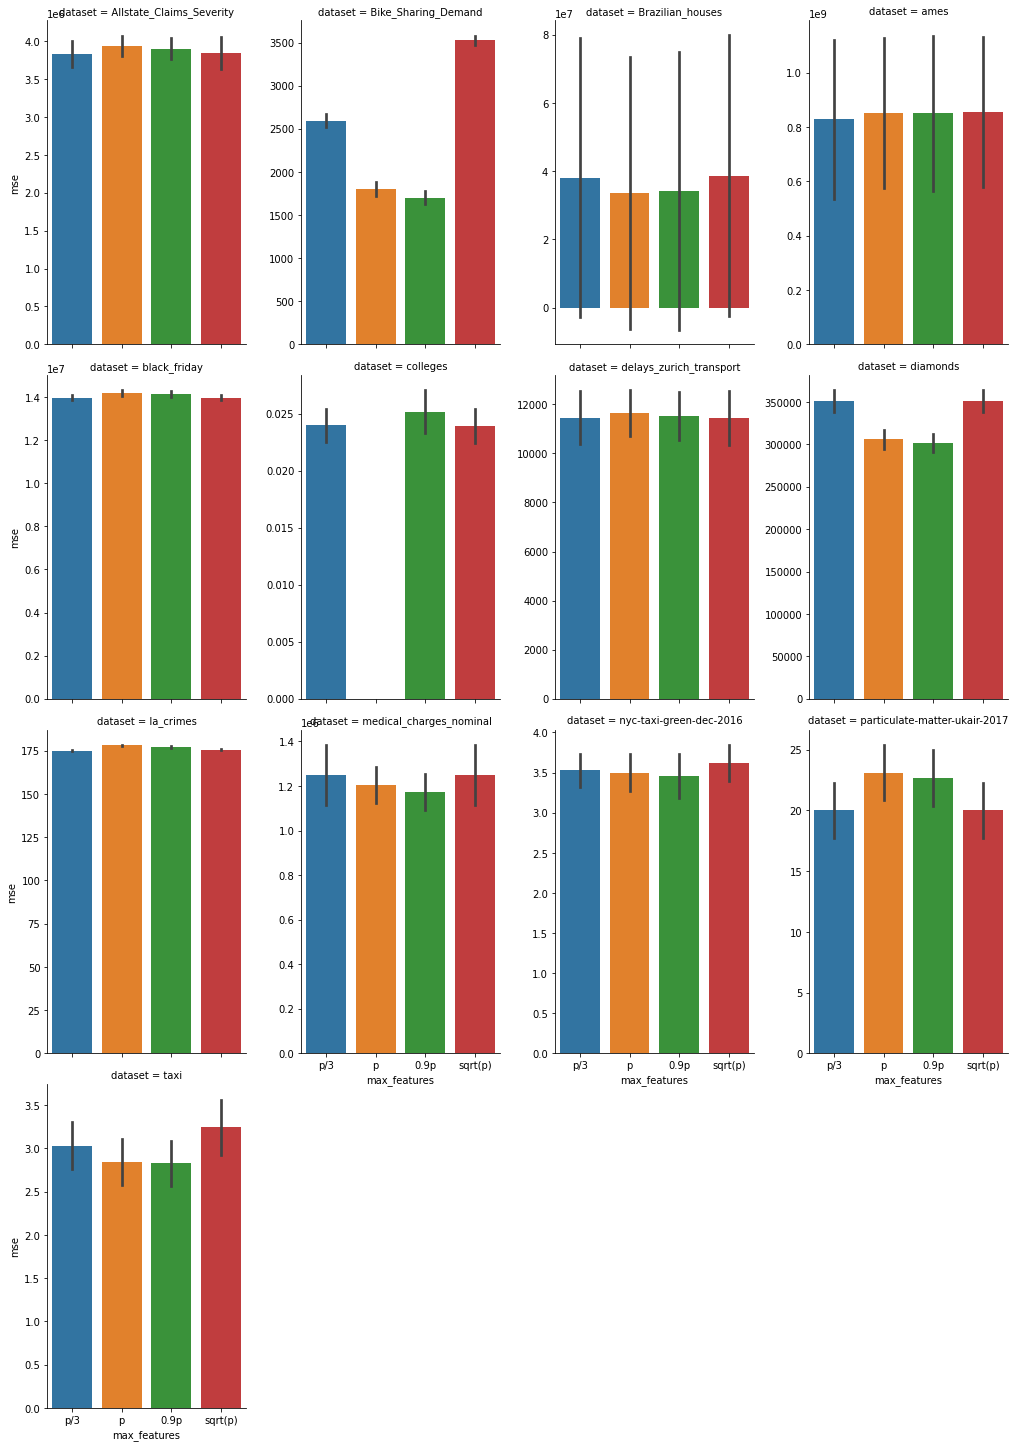

In [8]:
# Easiest way to get bars is to expand data!!!
df_tmp1 = df.copy()
df_tmp1["mse"] = df_tmp1["mse"] - df_tmp1["mse_std"]
df_tmp2 = df.copy()
df_tmp2["mse"] = df_tmp2["mse"] + df_tmp2["mse_std"]
df_tmp = pd.concat([df_tmp1, df_tmp2])

del (df_tmp1, df_tmp2)

sns.catplot(
    x="max_features",
    y="mse",  # hue="smoker",
    col="dataset",
    aspect=0.7,
    kind="bar",
    data=df_tmp.sort_values("dataset"),
    sharey=False,
    col_wrap=4,
    ci="sd",
)

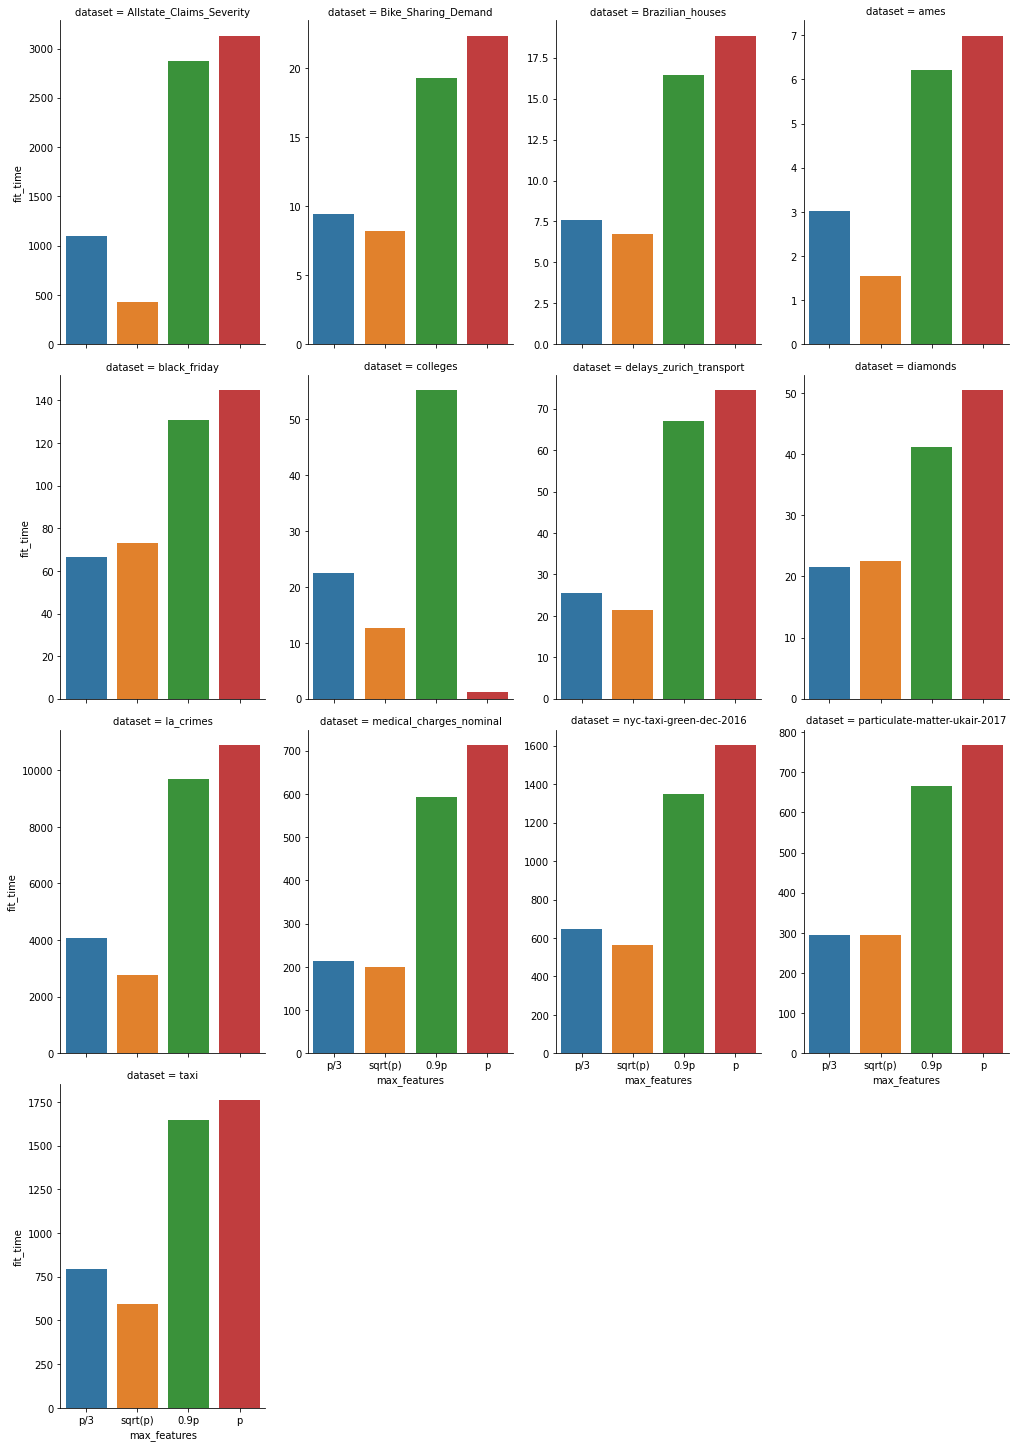

In [9]:
sns.catplot(
    x="max_features",
    y="fit_time",
    col="dataset",
    aspect=0.7,
    kind="bar",
    data=df.sort_values("dataset"),
    sharey=False,
    col_wrap=4,
)